# Challenge

Present and near-future observational facilities on the ground or in space have the capacity to discover and observe planets like the Earth. One key for such discovery to be possible is to know where to search and to identify stars around which such Earth twins could exist, based, for example, on the properties of other planets (easier to discover) orbiting the same star.
Purpose

## Purpose

The goal of this challenge is to develop an AI algorithm capable of capturing correlations and statistical relationships between planets in the same planetary system. Such an algorithm should be able to generate a large number of unique synthetic planetary systems with little computational cost. These synthetic systems can be used, for example, to guide observational campaigns, as described above.
Current Situation

## Current Situation

Numerical calculations of planetary system formation are very demanding in terms of computing power. These synthetic planetary systems can, however, provide access to correlations, as predicted in a given numerical framework, between the properties of planets in the same system. Such correlations can, in return, be used to guide and prioritise observational campaigns aimed at discovering certain types of planets, such as Earth-like planets.
Activities

## Activities

1. Data Analysis: Play with data composed of planets inside planetary systems generated from numerical simulations (Bern model).
2. Model Development: Train an AI model to understand statistical correlations between planets in a planetary system and to generate more.
3. Validation: Validate the model's accuracy using the provided (original) dataset.
4. Generation: Use the model to generate more planetary systems that can be unique.
5. Visualization: Create visualizations to present the findings.
6. Reporting: Document the progress, results, and algorithms used.

## Solve

### Load Data

In [1]:
import pandas as pd

# Load the harder dataset to understand its structure
harder_data = pd.read_csv('Harder Dataset.csv')
harder_data

,system_number,a,total_mass,r
0,1,0.922060,1.845780,10.138465
1,1,6.394738,2.813472,4.433379
2,1,0.187501,0.106468,0.492372
3,1,0.822920,1.788968,11.309450
4,1,3.074074,0.272204,5.370356
...,...,...,...,...
12306,1000,2.170678,0.199985,0.770126
12307,1000,0.164692,0.562657,0.817523
12308,1000,6.184137,0.101117,0.633028
12309,1000,6.177185,0.172572,0.737238


### Description of the Dataset

- `system_number`: which system a planet is part of

-  `a`: represents semi-major axis (in AU)

- `total_mass`: mass of planet (in earth masses)

- `r`: radius of planet (in earth radii). So we need to generate new systems.

## Exploration

### Planets per System

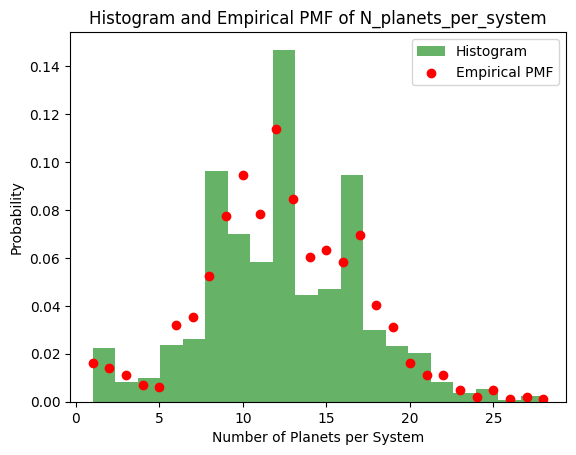

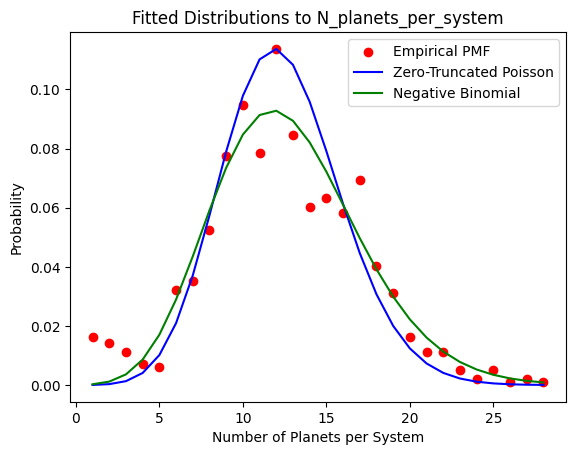

Fitted parameters for Negative Binomial: [25.68236642  0.66766726]


In [2]:
# The issue arises because the curve_fit function is unable to converge to optimal parameters within the maximum number of function evaluations (maxfev).
# This is likely due to the size and complexity of the dataset, which makes the optimization problem more challenging.
# Specifically, the empirical PMF derived from the larger dataset may have more variability, making it harder to fit the Negative Binomial distribution.

# To address this, we can:
# 1. Increase the maxfev parameter further to allow more iterations for convergence.
# 2. Provide better initial guesses for the parameters (p0) to help the optimization algorithm.
# 3. Use a different optimization method or library if curve_fit continues to struggle.

# Let's modify the code to implement these changes.

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, nbinom
from scipy.optimize import curve_fit

# Generate system-level statistics from the harder_data DataFrame
harder_system_stats = harder_data.groupby('system_number').size().reset_index(name='planet_count')

# System-level counts
# N_systems and N_planets_per_system
N_systems = harder_system_stats['system_number'].nunique()
N_planets_per_system = harder_system_stats['planet_count']

# Histogram of N_planets_per_system
plt.hist(N_planets_per_system, bins=20, density=True, alpha=0.6, color='g', label='Histogram')

# Empirical PMF
unique_counts, counts = np.unique(N_planets_per_system, return_counts=True)
empirical_pmf = counts / counts.sum()
plt.scatter(unique_counts, empirical_pmf, color='red', label='Empirical PMF')

plt.xlabel('Number of Planets per System')
plt.ylabel('Probability')
plt.title('Histogram and Empirical PMF of N_planets_per_system')
plt.legend()
plt.show()

# Fit a zero-truncated Poisson distribution
mean_planets = N_planets_per_system.mean()
poisson_pmf = poisson.pmf(unique_counts, mean_planets)
poisson_pmf = poisson_pmf / poisson_pmf.sum()  # Normalize for zero-truncation

# Define a function for the Negative Binomial PMF
def negative_binomial_pmf(k, r, p):
    return nbinom.pmf(k, r, p)

# Fit a Negative Binomial distribution using curve_fit
# Increase maxfev further and provide better initial guesses
try:
    params, _ = curve_fit(
        lambda k, r, p: negative_binomial_pmf(k, r, p),
        unique_counts,
        empirical_pmf,
        p0=[2, 0.5],  # Adjusted initial guesses
        maxfev=5000  # Increased maxfev
    )
    nbinom_pmf = negative_binomial_pmf(unique_counts, *params)

    # Plot fitted distributions
    plt.scatter(unique_counts, empirical_pmf, color='red', label='Empirical PMF')
    plt.plot(unique_counts, poisson_pmf, label='Zero-Truncated Poisson', color='blue')
    plt.plot(unique_counts, nbinom_pmf, label='Negative Binomial', color='green')

    plt.xlabel('Number of Planets per System')
    plt.ylabel('Probability')
    plt.title('Fitted Distributions to N_planets_per_system')
    plt.legend()
    plt.show()

    print("Fitted parameters for Negative Binomial:", params)

except RuntimeError as e:
    print("Error during curve fitting:", e)

### Planet Level Marginals

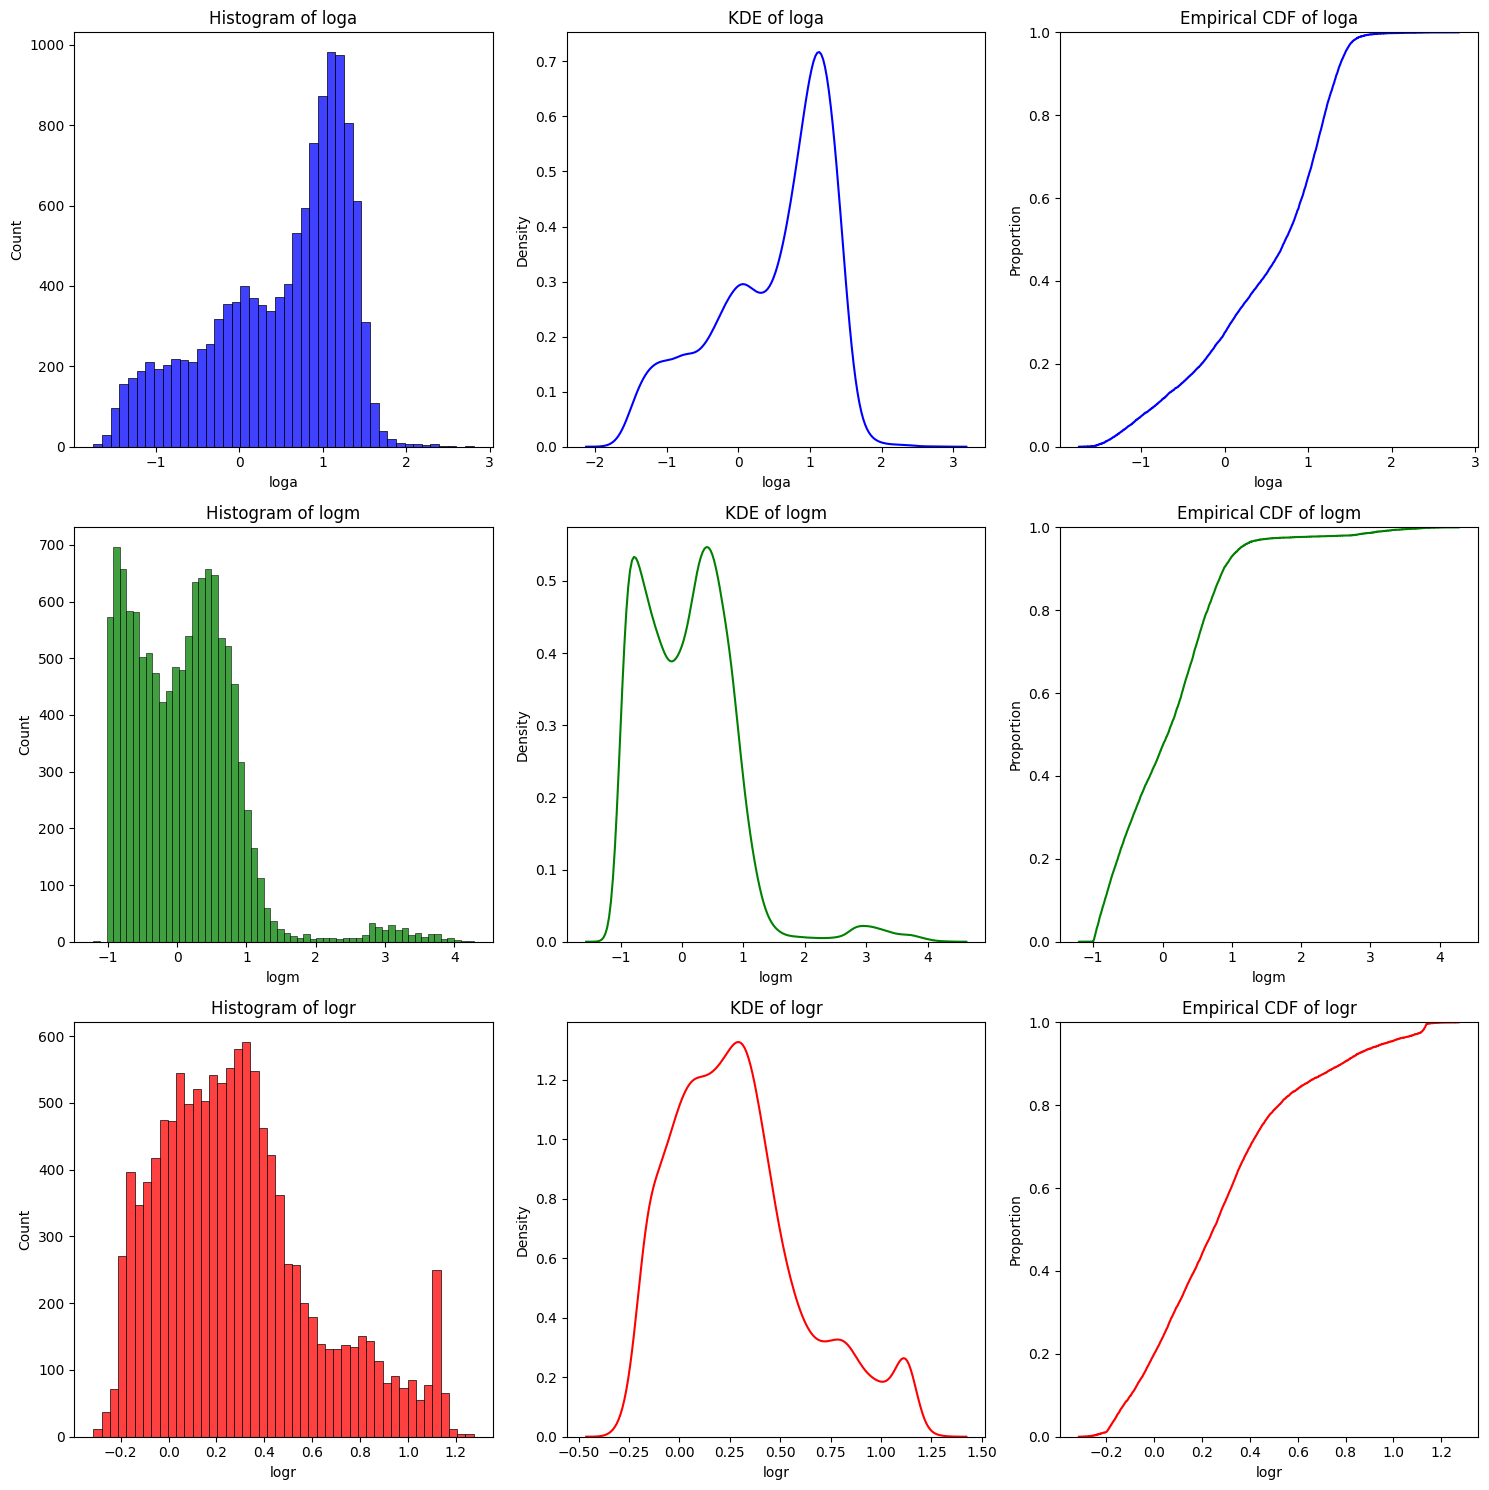

,loga,logm,logr
count,12311.000000,12311.000000,12311.000000
mean,0.476902,0.084946,0.288226
std,0.818870,0.776375,0.325495
min,-1.747821,-1.207603,-0.314100
25%,-0.089841,-0.548437,0.044505
50%,0.728757,0.071784,0.247393
75%,1.132274,0.546405,0.450009
max,2.808469,4.279156,1.274472


In [3]:
import seaborn as sns

# Transform to logs
harder_data['loga'] = np.log10(harder_data['a'])
harder_data['logm'] = np.log10(harder_data['total_mass'])
harder_data['logr'] = np.log10(harder_data['r'])

# Plot histograms, KDEs, and empirical CDFs for loga, logm, logr
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# loga
sns.histplot(harder_data['loga'], kde=False, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Histogram of loga')
sns.kdeplot(harder_data['loga'], ax=axes[0, 1], color='blue')
axes[0, 1].set_title('KDE of loga')
sns.ecdfplot(harder_data['loga'], ax=axes[0, 2], color='blue')
axes[0, 2].set_title('Empirical CDF of loga')

# logm
sns.histplot(harder_data['logm'], kde=False, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Histogram of logm')
sns.kdeplot(harder_data['logm'], ax=axes[1, 1], color='green')
axes[1, 1].set_title('KDE of logm')
sns.ecdfplot(harder_data['logm'], ax=axes[1, 2], color='green')
axes[1, 2].set_title('Empirical CDF of logm')

# logr
sns.histplot(harder_data['logr'], kde=False, ax=axes[2, 0], color='red')
axes[2, 0].set_title('Histogram of logr')
sns.kdeplot(harder_data['logr'], ax=axes[2, 1], color='red')
axes[2, 1].set_title('KDE of logr')
sns.ecdfplot(harder_data['logr'], ax=axes[2, 2], color='red')
axes[2, 2].set_title('Empirical CDF of logr')

plt.tight_layout()
plt.show()

harder_data[['loga', 'logm', 'logr']].describe()

### Intra-System Structure

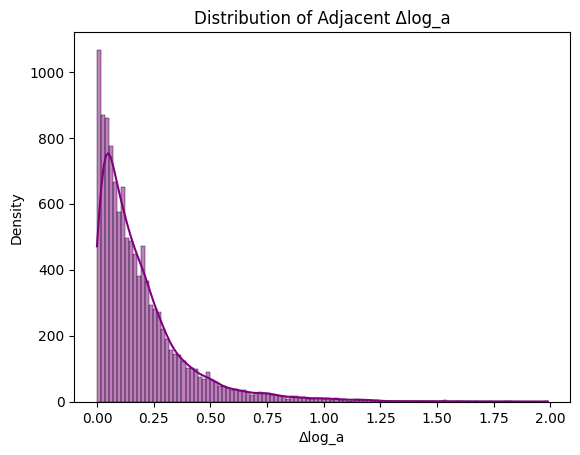

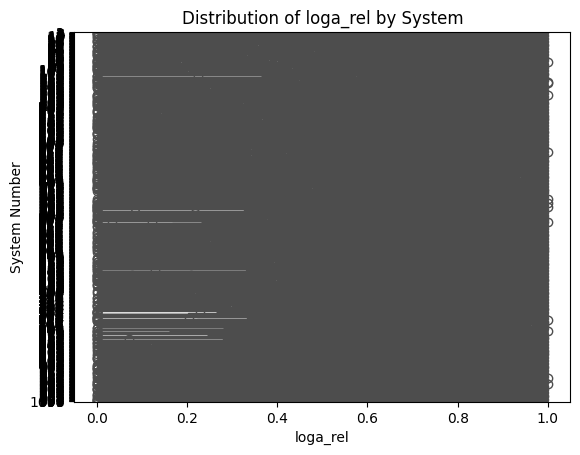

,delta_loga,loga_rel
count,11317.000000,12295.000000
mean,0.192464,0.643928
std,0.205955,0.323295
min,0.000008,0.000000
25%,0.053846,0.411686
50%,0.131528,0.750016
75%,0.253779,0.922723
max,1.988985,1.000000


In [4]:
# Compute adjacent log spacing: Δlog_a_j = log10(a_{j+1}) - log10(a_j)
harder_data_sorted = harder_data.sort_values(by=['system_number', 'a'])
harder_data_sorted['delta_loga'] = harder_data_sorted.groupby('system_number')['loga'].diff()

# Plot distribution of adjacent Δlog_a
sns.histplot(harder_data_sorted['delta_loga'].dropna(), kde=True, color='purple')
plt.xlabel('Δlog_a')
plt.ylabel('Density')
plt.title('Distribution of Adjacent Δlog_a')
plt.show()

# Distribution of a normalized by system scale
harder_data_sorted['loga_rel'] = harder_data_sorted.groupby('system_number')['loga'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Inspect patterns by planet rank
sns.boxplot(x=harder_data_sorted['loga_rel'], y=harder_data_sorted['system_number'], orient='h', color='orange')
plt.xlabel('loga_rel')
plt.ylabel('System Number')
plt.title('Distribution of loga_rel by System')
plt.show()

harder_data_sorted[['delta_loga', 'loga_rel']].describe()

### Correlations

In [5]:
!pip install statsmodels

# Re-run the correlation and regression analysis now that statsmodels is installed
import statsmodels.api as sm

# Correlations
# Pairwise correlations globally
correlation_matrix = harder_data[['loga', 'logm', 'logr']].corr()

# Average within-system correlations
def within_system_corr(group):
    return group[['loga', 'logm', 'logr']].corr().mean().mean()

average_within_system_corr = harder_data.groupby('system_number').apply(within_system_corr).mean()

# Fit simple regressions
# logm ~ logr
X_logr = sm.add_constant(harder_data['logr'])
model_logm_logr = sm.OLS(harder_data['logm'], X_logr).fit()

# logm ~ loga
X_loga = sm.add_constant(harder_data['loga'])
model_logm_loga = sm.OLS(harder_data['logm'], X_loga).fit()

# logr ~ loga
X_loga_for_logr = sm.add_constant(harder_data['loga'])
model_logr_loga = sm.OLS(harder_data['logr'], X_loga_for_logr).fit()

correlation_matrix, average_within_system_corr, model_logm_logr.summary(), model_logm_loga.summary(), model_logr_loga.summary()


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


(          loga      logm      logr
 loga  1.000000 -0.533856 -0.297376
 logm -0.533856  1.000000  0.776653
 logr -0.297376  0.776653  1.000000,
 0.2953364216044028,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                   logm   R-squared:                       0.603
 Model:                            OLS   Adj. R-squared:                  0.603
 Method:                 Least Squares   F-statistic:                 1.871e+04
 Date:                Fri, 19 Sep 2025   Prob (F-statistic):               0.00
 Time:                        08:37:00   Log-Likelihood:                -8662.4
 No. Observations:               12311   AIC:                         1.733e+04
 Df Residuals:                   12309   BIC:                         1.734e+04
 Df Model:                           1                                         
 Covariance Type:            nonrobust                          

## Feature engineering / transforms

1. Rank Planets Within Each System:
   - `harder_data_sorted['rank_within_system'] = harder_data_sorted.groupby('system_number').cumcount() + 1`
   - This assigns a rank to each planet within its respective planetary system (`system_number`), based on the order of appearance in the sorted DataFrame. The rank starts at 1 for the first planet in each system.

2. Compute System-Level Summaries:
   - `system_scales = harder_data_sorted.groupby('system_number')['loga'].agg(['max', 'median', 'mean']).reset_index()`
   - For each planetary system, the code calculates three summary statistics of the `loga` (logarithm of the semi-major axis):
     - `max`: The largest value of `loga` in the system.
     - `median`: The median value of `loga` in the system.
     - `mean`: The average value of `loga` in the system.
   - These summaries are stored in a new DataFrame called `system_scales`.

3. Rename Columns for Clarity:
   - `system_scales.columns = ['system_number', 'system_scale_max', 'system_scale_median', 'system_scale_mean']`
   - The columns in `system_scales` are renamed to clearly indicate that they represent system-level statistics.

4. Merge System-Level Summaries Back:
   - `harder_data_sorted = harder_data_sorted.merge(system_scales, on='system_number', how='left')`
   - The system-level summaries (`system_scale_max`, `system_scale_median`, `system_scale_mean`) are merged back into the main DataFrame (`harder_data_sorted`) based on the `system_number`. This ensures that each planet in a system has access to its system's summary statistics.

5. Adjacent Log Ratio (Δlog_a):
   - The adjacent log ratio (`delta_loga`) was previously computed and is already available in the DataFrame. This variable represents the difference in `loga` between consecutive planets within the same system.

6. Preview the Result:
   - `harder_data_sorted[['system_number', 'rank_within_system', 'system_scale_max', 'system_scale_median', 'system_scale_mean', 'delta_loga']].head()`
   - This displays the first few rows of the DataFrame, showing the newly created features (`rank_within_system`, `system_scale_max`, `system_scale_median`, `system_scale_mean`, and `delta_loga`) for inspection.

In [6]:
# Create rank_within_system (1..k)
harder_data_sorted['rank_within_system'] = harder_data_sorted.groupby('system_number').cumcount() + 1

# Create system-level summaries: system_scale = max(loga) or median(loga) or mean(loga)
system_scales = harder_data_sorted.groupby('system_number')['loga'].agg(['max', 'median', 'mean']).reset_index()
system_scales.columns = ['system_number', 'system_scale_max', 'system_scale_median', 'system_scale_mean']

# Merge system-level summaries back into the main dataset
harder_data_sorted = harder_data_sorted.merge(system_scales, on='system_number', how='left')

# Adjacent log ratio or Δlog_a is already computed as 'delta_loga'

harder_data_sorted[['system_number', 'rank_within_system', 'system_scale_max', 'system_scale_median', 'system_scale_mean', 'delta_loga']].head()

,system_number,rank_within_system,system_scale_max,system_scale_median,system_scale_mean,delta_loga
0,1,1,1.418794,0.052705,0.293713,NaN
1,1,2,1.418794,0.052705,0.293713,0.638709
2,1,3,1.418794,0.052705,0.293713,0.317315
3,1,4,1.418794,0.052705,0.293713,0.132205
4,1,5,1.418794,0.052705,0.293713,0.087637


## Solution Approaches

### Approach 1: empirical resample + jitter

Resample whole systems from the real dataset and perturb in log space.

Parameters: sigma_a, sigma_m, sigma_r small (e.g., 0.02–0.2 dex). Tune to trade off realism vs novelty.

Pros: trivial to implement; preserves all intra-system patterns in sampled systems.
Cons: restricted to shapes present in data; unrealistic if you need novel architectures.

In [7]:
import numpy as np
import pandas as pd

# Parameters for jitter
sigma_a = 0.1
sigma_m = 0.1
sigma_r = 0.1
N_synthetic_systems = 25000

# Placeholder for synthetic systems
synthetic_systems = []

# Generate synthetic systems
for _ in range(N_synthetic_systems):
    # Sample a real system uniformly
    sampled_system_number = np.random.choice(harder_data_sorted['system_number'].unique())
    sampled_system = harder_data_sorted[harder_data_sorted['system_number'] == sampled_system_number].copy()

    # Apply jitter to log-values
    sampled_system['loga'] += np.random.normal(0, sigma_a, size=len(sampled_system))
    sampled_system['logm'] += np.random.normal(0, sigma_m, size=len(sampled_system))
    sampled_system['logr'] += np.random.normal(0, sigma_r, size=len(sampled_system))

    # Sort by a' (loga') and reassign ranks
    sampled_system = sampled_system.sort_values(by='loga').reset_index(drop=True)
    sampled_system['rank_within_system'] = np.arange(1, len(sampled_system) + 1)

    # Optional clipping to physical bounds (e.g., loga > -2, logm > -2, logr > -2)
    sampled_system['loga'] = sampled_system['loga'].clip(lower=-2)
    sampled_system['logm'] = sampled_system['logm'].clip(lower=-2)
    sampled_system['logr'] = sampled_system['logr'].clip(lower=-2)

    # Append to synthetic systems
    synthetic_systems.append(sampled_system)

# Combine all synthetic systems into a single DataFrame
synthetic_data_app1 = pd.concat(synthetic_systems, ignore_index=True)
synthetic_data_app1

,system_number,a,total_mass,r,loga,logm,logr,delta_loga,loga_rel,rank_within_system,system_scale_max,system_scale_median,system_scale_mean
0,236,42.748794,1149.018659,13.700592,1.567582,3.045485,1.063649,NaN,NaN,1,1.630924,1.630924,1.630924
1,206,0.085549,0.380212,0.722514,-1.079287,-0.294513,0.105022,NaN,0.000000,1,1.136647,0.253845,0.228489
2,206,0.212191,1.867359,1.626827,-0.569989,0.192038,0.115698,0.394511,0.178963,2,1.136647,0.253845,0.228489
3,206,0.415432,2.177810,2.777790,-0.508446,0.404321,0.534850,0.117708,0.311320,3,1.136647,0.253845,0.228489
4,206,0.316805,2.117939,1.232626,-0.468412,0.281775,0.095845,0.174064,0.257924,4,1.136647,0.253845,0.228489
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309429,556,2.000615,4.744330,2.013598,0.357580,0.712365,0.312232,0.138691,0.659296,6,1.097733,0.231818,0.177486
309430,556,4.141279,1.542597,2.792477,0.489871,0.089199,0.346660,0.315971,0.794441,7,1.097733,0.231818,0.177486
309431,556,6.642461,4.438882,2.730452,0.793605,0.461152,0.497342,0.205195,0.882206,8,1.097733,0.231818,0.177486
309432,556,11.750165,1.273182,2.457265,1.118458,0.118940,0.506662,0.247715,0.988157,9,1.097733,0.231818,0.177486


The synthetic planetary systems have been generated with jitter applied to the log-values of semi-major axis, mass, and radius. The systems are sorted, ranks reassigned, and values clipped to physical bounds.

### Approach 2: COPULA / joint sampling

Model marginals for each variable (log-a, log-m, log-r) then capture joint dependence using a copula (e.g., Gaussian copula). For intra-system dependence, include a per-system latent that shifts planets in the same system.

Pros: flexible, explicitly models dependencies, can generate novel combinations.
Cons: you must estimate marginals robustly; copulas assume a particular dependence family (Gaussian copula is common but not always ideal).

In [8]:
from scipy.stats import norm, gaussian_kde
from sklearn.covariance import EmpiricalCovariance
import numpy as np
import pandas as pd

# Step 1: Estimate marginals globally using KDE
kde_loga = gaussian_kde(harder_data_sorted['loga'])
kde_logm = gaussian_kde(harder_data_sorted['logm'])
kde_logr = gaussian_kde(harder_data_sorted['logr'])

# Transform observations to uniforms u = F_empirical(x)
harder_data_sorted['u_loga'] = harder_data_sorted['loga'].apply(lambda x: kde_loga.integrate_box_1d(-np.inf, x))
harder_data_sorted['u_logm'] = harder_data_sorted['logm'].apply(lambda x: kde_logm.integrate_box_1d(-np.inf, x))
harder_data_sorted['u_logr'] = harder_data_sorted['logr'].apply(lambda x: kde_logr.integrate_box_1d(-np.inf, x))

# Transform uniforms to normals z = Φ^{-1}(u)
harder_data_sorted['z_loga'] = norm.ppf(harder_data_sorted['u_loga'])
harder_data_sorted['z_logm'] = norm.ppf(harder_data_sorted['u_logm'])
harder_data_sorted['z_logr'] = norm.ppf(harder_data_sorted['u_logr'])

# Step 2: Fit a correlation matrix Σ of (z_loga, z_logm, z_logr)
z_data = harder_data_sorted[['z_loga', 'z_logm', 'z_logr']].dropna()
cov_estimator = EmpiricalCovariance().fit(z_data)
correlation_matrix = cov_estimator.covariance_

# Step 3: Generate synthetic data
synthetic_systems = []
N_synthetic_systems = 25000

for _ in range(N_synthetic_systems):
    # Draw K ~ empirical_Nplanets_dist
    K = np.random.choice(unique_counts, p=empirical_pmf)

    # Draw multivariate normal z_j ~ N(0, Σ)
    z_samples = np.random.multivariate_normal(mean=[0, 0, 0], cov=correlation_matrix, size=K)

    # Transform z_j back to uniforms u_j = Φ(z_j)
    u_samples = norm.cdf(z_samples)

    # Transform uniforms back to original scale x_j = F^{-1}(u_j)
    loga_samples = np.array([kde_loga.resample(1).flatten()[0] for u in u_samples[:, 0]])
    logm_samples = np.array([kde_logm.resample(1).flatten()[0] for u in u_samples[:, 1]])
    logr_samples = np.array([kde_logr.resample(1).flatten()[0] for u in u_samples[:, 2]])

    # Convert log values back to original scale
    a_samples = 10 ** loga_samples
    total_mass_samples = 10 ** logm_samples
    r_samples = 10 ** logr_samples

    # Create synthetic system DataFrame
    synthetic_system = pd.DataFrame({
        'loga': loga_samples,
        'logm': logm_samples,
        'logr': logr_samples,
        'a': a_samples,
        'total_mass': total_mass_samples,
        'r': r_samples
    })

    # Add system-level metadata to match Approach 1
    synthetic_system['system_number'] = _ + 1
    synthetic_system['rank_within_system'] = range(1, K + 1)

    # Append to synthetic systems
    synthetic_systems.append(synthetic_system)

# Combine all synthetic systems into a single DataFrame
synthetic_data_copula = pd.concat(synthetic_systems, ignore_index=True)
synthetic_data_copula

,loga,logm,logr,a,total_mass,r,system_number,rank_within_system
0,1.429163,-0.825617,0.010828,26.863535,0.149411,1.025245,1,1
1,0.886435,-0.180446,0.222575,7.699020,0.660015,1.669457,1,2
2,-0.281175,0.712041,-0.095866,0.523389,5.152768,0.801925,1,3
3,-0.180979,-0.633339,0.678011,0.659206,0.232627,4.764435,1,4
4,2.516135,0.384830,0.020154,328.197231,2.425663,1.047501,1,5
...,...,...,...,...,...,...,...,...
307560,0.300234,0.921544,-0.109365,1.996338,8.347253,0.777383,25000,11
307561,-0.129011,0.171396,0.768084,0.743000,1.483870,5.862514,25000,12
307562,0.330665,-0.938333,-0.129449,2.141237,0.115257,0.742251,25000,13
307563,0.631361,0.718902,0.376998,4.279181,5.234820,2.382309,25000,14


### Approach 3: HIERARCHICAL BAYESIAN GENERATIVE MODEL

Treat each system as generated from a system-level latent (scale/architecture). Model planet properties conditional on the system latent and planet rank. This gives interpretable parameters and naturally preserves within-system correlations via random effects.

1. System-Level Latent Parameters:
   - `mu_s`: Mean of the system-level latent variable. This represents the average scale or architecture of planetary systems.
   - `sigma_s`: Standard deviation of the system-level latent variable. This captures the variability in scales or architectures across different planetary systems.

2. Planet-Level Parameters:
   - `alpha0`: Intercept for the planet-level model. This is the baseline value for the logarithm of the semi-major axis (`loga`) of planets.
   - `alpha1`: Slope for the rank effect in the planet-level model. This captures how the logarithm of the semi-major axis (`loga`) changes with the rank of the planet within the system.
   - `beta0`: Intercept for the logarithm of the mass (`logm`) of planets. This is the baseline value for the mass of planets.
   - `beta1`: Slope for the logarithm of the semi-major axis (`loga`) in the mass model. This captures how the mass of planets depends on their semi-major axis.
   - `beta2`: Slope for the logarithm of the radius (`logr`) in the mass model. This captures how the mass of planets depends on their radius.

3. Random Effects:
   - `b_i`: System-specific random effect for the logarithm of the semi-major axis (`loga`). This accounts for variations in the semi-major axis across different systems.
   - `b_prime_i`: System-specific random effect for the logarithm of the mass (`logm`). This accounts for variations in the mass across different systems.

4. Noise Parameters:
   - `sigma_a`: Standard deviation of the noise in the logarithm of the semi-major axis (`loga`). This captures the variability in the semi-major axis that is not explained by the model.
   - `sigma_m`: Standard deviation of the noise in the logarithm of the mass (`logm`). This captures the variability in the mass that is not explained by the model.
   - `sigma_r`: Standard deviation of the noise in the logarithm of the radius (`logr`). This captures the variability in the radius that is not explained by the model.

5. Latent Variables:
   - `s_i`: System-level latent variable. This represents the scale or architecture of a specific planetary system.
   - `loga_ij`: Logarithm of the semi-major axis for planet `j` in system `i`.
   - `logm_ij`: Logarithm of the mass for planet `j` in system `i`.
   - `logr_ij`: Logarithm of the radius for planet `j` in system `i`.

These parameters collectively define the hierarchical Bayesian generative model, allowing it to capture both system-level and planet-level variations while preserving the statistical relationships observed in the data.

Pros: highest fidelity; can express hierarchical behavior, borrow strength across ranks, explicitly model uncertainty.
Cons: heavier compute, more expertise required; MCMC on small dataset can still work well if priors are sensible.

In [9]:
import numpy as np
import pandas as pd

# Parameters for the hierarchical model
mu_s = 0.7844177520062057
sigma_s = 0.6583803912753419
sigma_b = 0.48849021635284934
sigma_r = 0.6650052454763183
sigma_m = 0.11551050725536592

# Rank-specific parameters (example values, can be tuned)
mu_rank = {1: -0.41354525522855723, 2: 0.6154700751371269, 3: -0.7861707573708009, 4: -0.6176370068351965, 5: -0.6104519370864728}
sigma_a_rank = {1: 0.07901177890230987, 2: 0.07509563368259634, 3: 0.0292738569532166, 4: 0.06333842011271064, 5: 0.02802336044188404}
gamma_rank = {1: -0.045501651713602105, 2: -0.8482279239517564, 3: -0.6294392778910575, 4: -0.651308761419564, 5: -0.8225511378024634}

alpha0 = 0.13923216690601695
alpha1 = 0.14270414893781563
beta0 = 0.1378215432715184
beta1 = 0.5762397155790562
beta2 = 0.22503815840116356

# Number of synthetic systems to generate
N_synthetic_systems = 25000

# Placeholder for synthetic systems
synthetic_systems = []

# Generate synthetic systems
for i in range(N_synthetic_systems):
    # Sample number of planets in the system (K_i)
    K_i = np.random.choice(unique_counts, p=empirical_pmf)  # Using empirical PMF

    # Sample system scale (s_i)
    s_i = np.random.normal(mu_s, sigma_s)

    # Sample system-level random effects
    b_i = np.random.normal(0, sigma_b)
    b_prime_i = np.random.normal(0, sigma_b)

    # Placeholder for planets in the system
    planets = []

    for j in range(1, K_i + 1):
        rank = j

        # Sample loga_ij
        eps_a_ij = np.random.normal(0, sigma_a_rank.get(rank, 0.05))
        loga_ij = s_i + mu_rank.get(rank, 0.0) + eps_a_ij

        # Sample logr_ij
        logr_ij = np.random.normal(alpha0 + alpha1 * loga_ij + gamma_rank.get(rank, 0.0) + b_i, sigma_r)

        # Sample logm_ij
        logm_ij = np.random.normal(beta0 + beta1 * logr_ij + beta2 * loga_ij + b_prime_i, sigma_m)

        # Convert log values back to original scale
        a_ij = 10 ** loga_ij
        r_ij = 10 ** logr_ij
        total_mass_ij = 10 ** logm_ij

        # Append planet data
        planets.append({
            'system_number': i + 1,
            'rank': rank,
            'loga': loga_ij,
            'logr': logr_ij,
            'logm': logm_ij,
            'a': a_ij,
            'r': r_ij,
            'total_mass': total_mass_ij
        })

    # Append system data
    synthetic_systems.extend(planets)

# Combine all synthetic systems into a single DataFrame
synthetic_data_hierarchical = pd.DataFrame(synthetic_systems)
synthetic_data_hierarchical

,system_number,rank,loga,logr,logm,a,r,total_mass
0,1,1,0.808307,-0.668202,-0.858419,6.431415,0.214683,0.138542
1,1,2,1.858439,-1.292439,-0.706807,72.183619,0.050999,0.196423
2,1,3,0.471022,-0.574750,-0.724156,2.958163,0.266226,0.188731
3,1,4,0.706430,-2.243769,-1.698067,5.086627,0.005705,0.020042
4,1,5,0.724188,-0.685685,-0.519854,5.298923,0.206212,0.302096
...,...,...,...,...,...,...,...,...
309812,24999,7,1.177112,-1.085386,-0.669303,15.035310,0.082151,0.214140
309813,24999,8,1.136538,-1.225600,-0.767412,13.694237,0.059484,0.170839
309814,24999,9,1.165388,-0.262670,0.037177,14.634826,0.546173,1.089375
309815,24999,10,1.204883,0.292153,0.243778,16.028135,1.959536,1.752984


The hierarchical Bayesian generative model has been implemented, generating synthetic planetary systems with system-level and planet-level dependencies. The resulting data includes system numbers, planet ranks, and the generated log-scaled properties (loga, logr, logm).

### Approach 4: Concrete synthetic generation pipeline

Unlike pure resample+jitter (Approach 1), it can create new system architectures not directly in the dataset.

Unlike copula (Approach 2), it encodes system-level coherence: planets in one system are related through the shared system_scale and rank offsets.

Unlike your first attempt at hierarchical Bayes (Approach 3), it’s easier to fit and run while still reflecting the hierarchy.

1. Model the number of planets per system

- Empirically estimate the distribution of planets per system (K)

- You can fit a simple distribution (Poisson / Negative Binomial) or just resample directly from the empirical PMF.

2. Model a system-level “scale” in semi-major axis

- Each planetary system tends to have a maximum extent (max(log a)). 

- Fit the distribution of this system scale across your real systems (e.g., Normal in log-space or kernel density). 

- When generating, draw one system_scale per synthetic system.

3. Model planet positions relative to the system scale

- Sort planets in each real system by a.

- For each rank (1st, 2nd, …), compute offset from the system scale: \Delta a_{rank} = \log a_{rank} - \text{system_scale}

- Estimate mean & std of these offsets (per rank).

- When generating, for a planet of given rank, draw an offset from that distribution and add to the system scale.

- This captures the spacing pattern inside systems.

4. Model radius & mass conditionally

- Fit regressions (in log-space):
logr ~ α₀ + α₁*loga + α₂*rank + ε
logm ~ β₀ + β₁*logr + β₂*loga + β₃*rank + ε

- These regressions encode the empirical mass–radius relation and any weak dependence on distance/rank.

- Save residual distributions (variance or KDE).

- When generating, sample logr and logm using these regressions + noise.

5. Post-processing

- Clip to plausible ranges (e.g. exclude negative or unrealistic values).

- Add observational noise if you want the synthetic data to mimic measurement uncertainty.

- Optionally renormalize to match global marginals more tightly.

## !!!!There is an issue with generating to many systems using this approach. The bug is not yet fixed

In [10]:
import numpy as np
import pandas as pd

# Ensure harder_data_sorted is defined by sorting the harder_data DataFrame
harder_data_sorted = harder_data.sort_values(by=['system_number', 'a'])

# Define unique_counts and empirical_pmf for sampling number of planets
unique_counts, counts = np.unique(harder_data_sorted['system_number'], return_counts=True)
empirical_pmf = counts / counts.sum()

# Define functions for sampling and regression
def sample_from_P_K():
    # Example: sample number of planets from an empirical PMF
    return np.random.choice(unique_counts, p=empirical_pmf)

def sample_system_scale():
    # Example: sample system scale from a normal distribution
    return np.random.normal(mu_s, sigma_s)

def regression_radius(loga, rank):
    # Example: regression for radius
    return alpha0 + alpha1 * loga + gamma_rank.get(rank, 0.0)

def regression_mass(logr, loga, rank):
    # Example: regression for mass
    return beta0 + beta1 * logr + beta2 * loga

# Parameters
mu_s = 0.7844177520062057
sigma_s = 0.6583803912753419
sigma_r = 0.6650052454763183
sigma_m = 0.11551050725536592

mean_offset = {1: -0.41354525522855723, 2: 0.6154700751371269, 3: -0.7861707573708009, 4: -0.6176370068351965, 5: -0.6104519370864728}
sd_offset = {1: 0.07901177890230987, 2: 0.07509563368259634, 3: 0.0292738569532166, 4: 0.06333842011271064, 5: 0.02802336044188404}

gamma_rank = {1: -0.045501651713602105, 2: -0.8482279239517564, 3: -0.6294392778910575, 4: -0.651308761419564, 5: -0.8225511378024634}

alpha0 = 0.13923216690601695
alpha1 = 0.14270414893781563
beta0 = 0.1378215432715184
beta1 = 0.5762397155790562
beta2 = 0.22503815840116356

# Number of synthetic systems to generate
N_synthetic_systems = 5000

# Placeholder for synthetic systems
synthetic_systems = []

# Generate synthetic systems
for system_id in range(1, N_synthetic_systems + 1):
    # Step 1: number of planets
    K = sample_from_P_K()

    # Step 2: system scale
    s = sample_system_scale()

    # Step 3–4: planets
    planets = []
    for rank in range(1, K + 1):
        offset = np.random.normal(mean_offset.get(rank, 0.0), sd_offset.get(rank, 0.05))
        loga = s + offset

        logr = regression_radius(loga, rank) + np.random.normal(0, sigma_r)
        logm = regression_mass(logr, loga, rank) + np.random.normal(0, sigma_m)

        # Convert log values back to original scale
        a = 10 ** loga
        r = 10 ** logr
        total_mass = 10 ** logm

        planets.append((loga, logm, logr, a, r, total_mass))

    # Sort planets by loga
    planets.sort(key=lambda x: x[0])

    # Assign system number and save
    for planet in planets:
        synthetic_systems.append({
            'system_number': system_id,
            'loga': planet[0],
            'logm': planet[1],
            'logr': planet[2],
            'a': planet[3],
            'r': planet[4],
            'total_mass': planet[5]
        })

# Convert to DataFrame
synthetic_data_appr4 = pd.DataFrame(synthetic_systems)
synthetic_data_appr4

,system_number,loga,logm,logr,a,r,total_mass
0,1,-0.468841,-0.173854,-0.340680,0.339750,0.456373,0.670109
1,1,-0.388219,-0.449567,-0.697937,0.409054,0.200476,0.355168
2,1,-0.274652,-1.197501,-2.213053,0.531310,0.006123,0.063460
3,1,-0.241814,0.472546,0.331795,0.573041,2.146818,2.968560
4,1,0.165808,0.326325,0.226079,1.464901,1.682980,2.119946
...,...,...,...,...,...,...,...
2522136,5000,0.624147,0.311081,-0.093262,4.208687,0.806747,2.046827
2522137,5000,0.626255,0.625773,0.565381,4.229167,3.676045,4.224482
2522138,5000,0.629157,0.618868,0.523714,4.257518,3.339747,4.157845
2522139,5000,0.679416,1.020449,1.305984,4.779874,20.229458,10.482107


## Validation & Metrics

### Overlap

Overlap of the results in % between generated and source info.

In [11]:
import numpy as np
import pandas as pd

# Use harder_data as the source data
source_data = harder_data[['a', 'total_mass', 'r']]

# Extract generated data for each approach
# Ensure the columns match the source_data columns for comparison
generated_data_app1 = synthetic_data_appr4[['a', 'total_mass', 'r']]
generated_data_copula = synthetic_data_copula[['a', 'total_mass', 'r']]
generated_data_hierarchical = synthetic_data_hierarchical[['a', 'total_mass', 'r']]
generated_data_appr4 = synthetic_data_appr4[['a', 'total_mass', 'r']]

# Function to calculate overlap percentage
def calculate_overlap_percentage(source_data, generated_data, tolerance=0.1):
    # Align indices for comparison
    source_data, generated_data = source_data.align(generated_data, join='inner', axis=0)

    # Calculate the absolute difference between source and generated data
    difference = np.abs(source_data.values - generated_data.values)

    # Check if the difference is within the tolerance
    within_tolerance = (difference <= tolerance).all(axis=1)

    # Calculate the overlap percentage
    overlap_percentage = (within_tolerance.sum() / len(source_data)) * 100

    return overlap_percentage

# Calculate overlaps for each approach
overlap_app1 = calculate_overlap_percentage(source_data, generated_data_app1)
overlap_copula = calculate_overlap_percentage(source_data, generated_data_copula)
overlap_hierarchical = calculate_overlap_percentage(source_data, generated_data_hierarchical)
overlap_appr4 = calculate_overlap_percentage(source_data, generated_data_appr4)

# Create a DataFrame for better overview
overlap_data = {
    'Approach': ['Approach 1', 'Copula', 'Hierarchical', 'Approach 4'],
    'Overlap Percentage (%)': [overlap_app1, overlap_copula, overlap_hierarchical, overlap_appr4]
}

# Convert to DataFrame and display
overlap_df = pd.DataFrame(overlap_data)
print(overlap_df)

       Approach  Overlap Percentage (%)
0    Approach 1                0.000000
1        Copula                0.008123
2  Hierarchical                0.000000
3    Approach 4                0.000000


### Marginal-Test (KS Test / Cramer-von Mises)

The Kolmogorov-Smirnov (KS) Test and the Cramer-von Mises (CvM) Test are statistical tests used to compare two distributions or to test whether a sample comes from a specific distribution. They are commonly used in model validation to assess how well synthetic data matches real data.

1. KS Test:
   - The KS test measures the maximum difference between the empirical cumulative distribution functions (ECDFs) of two datasets or between a dataset and a theoretical distribution.
   - A small KS statistic indicates that the two distributions are similar, while a large KS statistic suggests significant differences.
   - The p-value indicates whether the observed difference is statistically significant. A high p-value (e.g., > 0.05) suggests that the distributions are not significantly different, which is desirable when validating synthetic data.

2. Cramer-von Mises Test:
   - The CvM test evaluates the squared differences between the ECDFs of two datasets or between a dataset and a theoretical distribution, integrated over the entire range of the data.
   - It is more sensitive to differences across the entire distribution, unlike the KS test, which focuses on the maximum difference.
   - A smaller CvM statistic indicates better agreement between the distributions. Like the KS test, a high p-value suggests no significant difference.

Good or Bad Values:
- Good Values: Small test statistics and high p-values (e.g., > 0.05) indicate that the synthetic data closely matches the real data, meaning the model is performing well.
- Bad Values: Large test statistics and low p-values (e.g., < 0.05) suggest significant differences between the distributions, indicating that the synthetic data does not adequately replicate the real data.

Results Approach 1:

  Variable  KS Statistic    KS P-Value  CVM Statistic  CVM P-Value
0     loga      0.010739  1.293498e-01       0.179486     0.311005
1     logm      0.023913  2.585467e-06       0.199637     0.268175
2     logr      0.031946  6.226060e-11       1.426252     0.000254


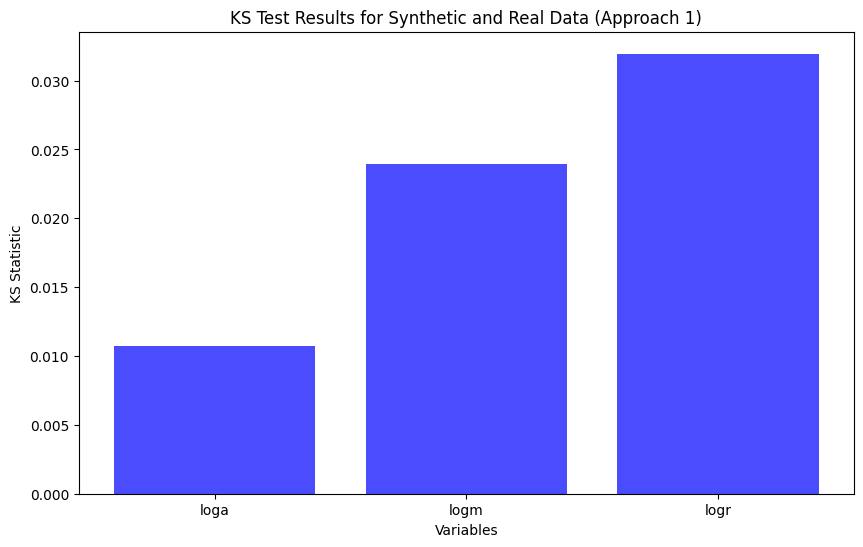

In [12]:
import numpy as np
from scipy.stats import ks_2samp, cramervonmises_2samp
import matplotlib.pyplot as plt
import pandas as pd

# Perform KS Test and Cramer-von Mises Test for Approach 1
ks_loga_approach1 = ks_2samp(harder_data_sorted['loga'], synthetic_data_app1['loga'])
ks_logm_approach1 = ks_2samp(harder_data_sorted['logm'], synthetic_data_app1['logm'])
ks_logr_approach1 = ks_2samp(harder_data_sorted['logr'], synthetic_data_app1['logr'])

cvm_loga_approach1 = cramervonmises_2samp(harder_data_sorted['loga'], synthetic_data_app1['loga'])
cvm_logm_approach1 = cramervonmises_2samp(harder_data_sorted['logm'], synthetic_data_app1['logm'])
cvm_logr_approach1 = cramervonmises_2samp(harder_data_sorted['logr'], synthetic_data_app1['logr'])

# Data for KS Test
ks_values_approach1 = [ks_loga_approach1.statistic, ks_logm_approach1.statistic, ks_logr_approach1.statistic]
ks_pvalues_approach1 = [ks_loga_approach1.pvalue, ks_logm_approach1.pvalue, ks_logr_approach1.pvalue]

# Data for Cramer-von Mises Test
cvm_values_approach1 = [cvm_loga_approach1.statistic, cvm_logm_approach1.statistic, cvm_logr_approach1.statistic]
cvm_pvalues_approach1 = [cvm_loga_approach1.pvalue, cvm_logm_approach1.pvalue, cvm_logr_approach1.pvalue]

# Combine results into a DataFrame for easy copying
results_table = pd.DataFrame({
    'Variable': ['loga', 'logm', 'logr'],
    'KS Statistic': ks_values_approach1,
    'KS P-Value': ks_pvalues_approach1,
    'CVM Statistic': cvm_values_approach1,
    'CVM P-Value': cvm_pvalues_approach1
})

print(results_table)

# Create a bar plot for KS Test
plt.figure(figsize=(10, 6))
plt.bar(results_table['Variable'], results_table['KS Statistic'], color='blue', alpha=0.7)
plt.xlabel('Variables')
plt.ylabel('KS Statistic')
plt.title('KS Test Results for Synthetic and Real Data (Approach 1)')
plt.show()

# Create a bar plot for Cramer-von Mises Test
# plt.figure(figsize=(10, 6))
# plt.bar(results_table['Variable'], results_table['CVM Statistic'], color='orange', alpha=0.7)
# plt.xlabel('Variables')
# plt.ylabel('CVM Statistic')
# plt.title('Cramer-von Mises Test Results for Synthetic and Real Data (Approach 1)')
# plt.show()

Result Approach 2:

  Variable  KS Statistic    KS P-Value  CVM Statistic  CVM P-Value
0     loga      0.015383  7.301655e-03       0.414372     0.066218
1     logm      0.027958  1.798402e-08       0.348613     0.099181
2     logr      0.014861  1.061595e-02       0.129565     0.458322


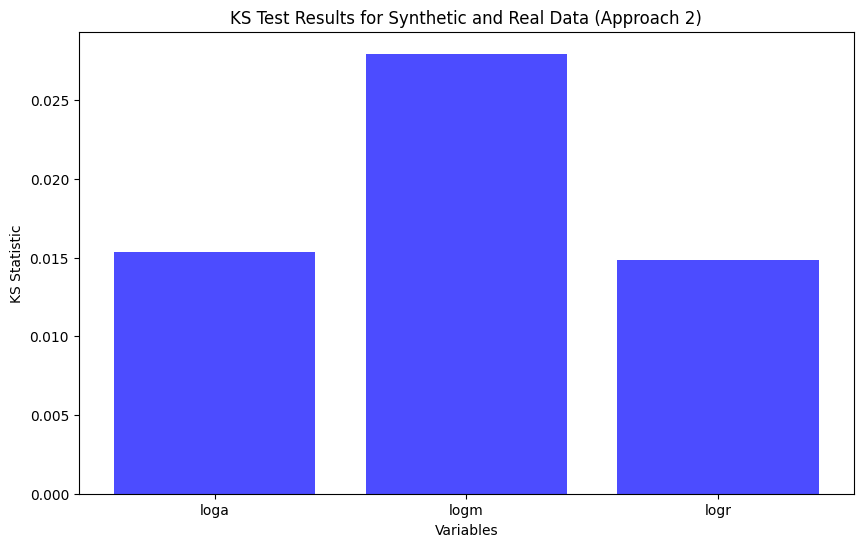

In [13]:
import numpy as np
from scipy.stats import ks_2samp, cramervonmises_2samp
import matplotlib.pyplot as plt
import pandas as pd

# Perform KS Test and Cramer-von Mises Test for Approach 2
ks_loga_approach2 = ks_2samp(harder_data_sorted['loga'], synthetic_data_copula['loga'])
ks_logm_approach2 = ks_2samp(harder_data_sorted['logm'], synthetic_data_copula['logm'])
ks_logr_approach2 = ks_2samp(harder_data_sorted['logr'], synthetic_data_copula['logr'])

cvm_loga_approach2 = cramervonmises_2samp(harder_data_sorted['loga'], synthetic_data_copula['loga'])
cvm_logm_approach2 = cramervonmises_2samp(harder_data_sorted['logm'], synthetic_data_copula['logm'])
cvm_logr_approach2 = cramervonmises_2samp(harder_data_sorted['logr'], synthetic_data_copula['logr'])

# Data for KS Test
ks_values_approach2 = [ks_loga_approach2.statistic, ks_logm_approach2.statistic, ks_logr_approach2.statistic]
ks_pvalues_approach2 = [ks_loga_approach2.pvalue, ks_logm_approach2.pvalue, ks_logr_approach2.pvalue]

# Data for Cramer-von Mises Test
cvm_values_approach2 = [cvm_loga_approach2.statistic, cvm_logm_approach2.statistic, cvm_logr_approach2.statistic]
cvm_pvalues_approach2 = [cvm_loga_approach2.pvalue, cvm_logm_approach2.pvalue, cvm_logr_approach2.pvalue]

# Combine results into a DataFrame for easy copying
results_table_approach2 = pd.DataFrame({
    'Variable': ['loga', 'logm', 'logr'],
    'KS Statistic': ks_values_approach2,
    'KS P-Value': ks_pvalues_approach2,
    'CVM Statistic': cvm_values_approach2,
    'CVM P-Value': cvm_pvalues_approach2
})

print(results_table_approach2)

# Create a bar plot for KS Test
plt.figure(figsize=(10, 6))
plt.bar(results_table_approach2['Variable'], results_table_approach2['KS Statistic'], color='blue', alpha=0.7)
plt.xlabel('Variables')
plt.ylabel('KS Statistic')
plt.title('KS Test Results for Synthetic and Real Data (Approach 2)')
plt.show()

# Create a bar plot for Cramer-von Mises Test
# plt.figure(figsize=(10, 6))
# plt.bar(results_table_approach2['Variable'], results_table_approach2['CVM Statistic'], color='orange', alpha=0.7)
# plt.xlabel('Variables')
# plt.ylabel('CVM Statistic')
# plt.title('Cramer-von Mises Test Results for Synthetic and Real Data (Approach 2)')
# plt.show()

Results Approach 3:

  Variable  KS Statistic     KS P-Value  CVM Statistic   CVM P-Value
0     loga      0.101827  2.420464e-107      41.910891  2.117600e-08
1     logm      0.139700  4.591000e-202     132.811563  6.301833e-08
2     logr      0.399623   0.000000e+00     484.493462  1.132275e-07


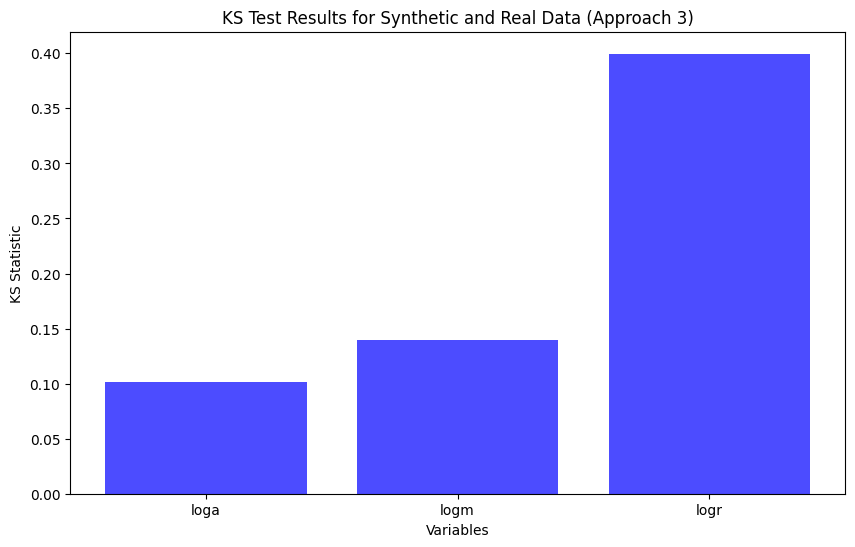

In [14]:
import numpy as np
from scipy.stats import ks_2samp, cramervonmises_2samp
import matplotlib.pyplot as plt
import pandas as pd

# Perform KS Test and Cramer-von Mises Test for Approach 3
ks_loga_approach3 = ks_2samp(harder_data_sorted['loga'], synthetic_data_hierarchical['loga'])
ks_logm_approach3 = ks_2samp(harder_data_sorted['logm'], synthetic_data_hierarchical['logm'])
ks_logr_approach3 = ks_2samp(harder_data_sorted['logr'], synthetic_data_hierarchical['logr'])

cvm_loga_approach3 = cramervonmises_2samp(harder_data_sorted['loga'], synthetic_data_hierarchical['loga'])
cvm_logm_approach3 = cramervonmises_2samp(harder_data_sorted['logm'], synthetic_data_hierarchical['logm'])
cvm_logr_approach3 = cramervonmises_2samp(harder_data_sorted['logr'], synthetic_data_hierarchical['logr'])

# Data for KS Test
ks_values_approach3 = [ks_loga_approach3.statistic, ks_logm_approach3.statistic, ks_logr_approach3.statistic]
ks_pvalues_approach3 = [ks_loga_approach3.pvalue, ks_logm_approach3.pvalue, ks_logr_approach3.pvalue]

# Data for Cramer-von Mises Test
cvm_values_approach3 = [cvm_loga_approach3.statistic, cvm_logm_approach3.statistic, cvm_logr_approach3.statistic]
cvm_pvalues_approach3 = [cvm_loga_approach3.pvalue, cvm_logm_approach3.pvalue, cvm_logr_approach3.pvalue]

# Combine results into a DataFrame for easy copying
results_table_approach3 = pd.DataFrame({
    'Variable': ['loga', 'logm', 'logr'],
    'KS Statistic': ks_values_approach3,
    'KS P-Value': ks_pvalues_approach3,
    'CVM Statistic': cvm_values_approach3,
    'CVM P-Value': cvm_pvalues_approach3
})

print(results_table_approach3)

# Create a bar plot for KS Test
plt.figure(figsize=(10, 6))
plt.bar(results_table_approach3['Variable'], results_table_approach3['KS Statistic'], color='blue', alpha=0.7)
plt.xlabel('Variables')
plt.ylabel('KS Statistic')
plt.title('KS Test Results for Synthetic and Real Data (Approach 3)')
plt.show()

# Create a bar plot for Cramer-von Mises Test
# plt.figure(figsize=(10, 6))
# plt.bar(results_table_approach3['Variable'], results_table_approach3['CVM Statistic'], color='orange', alpha=0.7)
# plt.xlabel('Variables')
# plt.ylabel('CVM Statistic')
# plt.title('Cramer-von Mises Test Results for Synthetic and Real Data (Approach 3)')
# plt.show()

Result Approach 4:

     Variable  KS Statistic     KS P-Value  CVM Statistic   CVM P-Value
0           a      0.154297  3.660514e-255     100.688430  2.862868e-08
1  total_mass      0.322913   0.000000e+00     538.342258  1.706454e-07
2           r      0.243798   0.000000e+00     197.243214  7.928099e-08


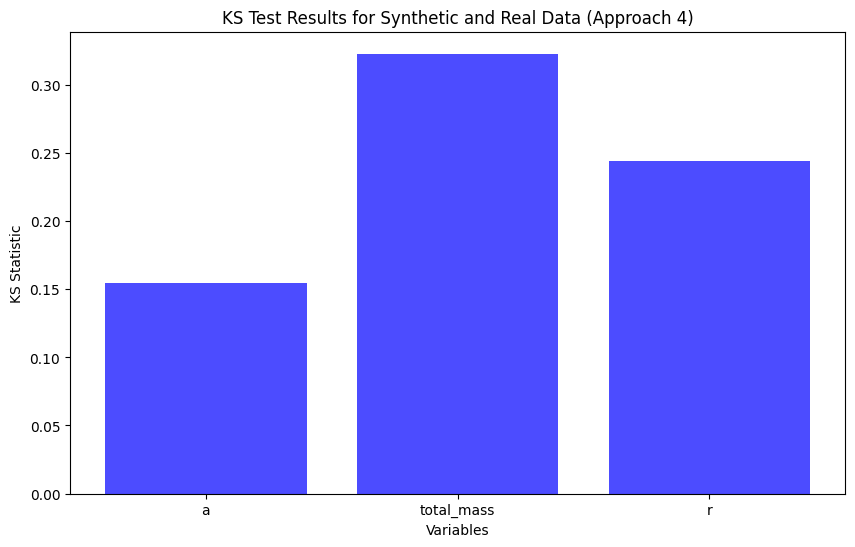

In [15]:
import numpy as np
from scipy.stats import ks_2samp, cramervonmises_2samp
import matplotlib.pyplot as plt
import pandas as pd

# Perform KS Test and Cramer-von Mises Test for Approach 4
ks_loga_approach4 = ks_2samp(harder_data_sorted['a'], synthetic_data_appr4['a'])
ks_logm_approach4 = ks_2samp(harder_data_sorted['total_mass'], synthetic_data_appr4['total_mass'])
ks_logr_approach4 = ks_2samp(harder_data_sorted['r'], synthetic_data_appr4['r'])

cvm_loga_approach4 = cramervonmises_2samp(harder_data_sorted['a'], synthetic_data_appr4['a'])
cvm_logm_approach4 = cramervonmises_2samp(harder_data_sorted['total_mass'], synthetic_data_appr4['total_mass'])
cvm_logr_approach4 = cramervonmises_2samp(harder_data_sorted['r'], synthetic_data_appr4['r'])

# Data for KS Test
ks_values_approach4 = [ks_loga_approach4.statistic, ks_logm_approach4.statistic, ks_logr_approach4.statistic]
ks_pvalues_approach4 = [ks_loga_approach4.pvalue, ks_logm_approach4.pvalue, ks_logr_approach4.pvalue]

# Data for Cramer-von Mises Test
cvm_values_approach4 = [cvm_loga_approach4.statistic, cvm_logm_approach4.statistic, cvm_logr_approach4.statistic]
cvm_pvalues_approach4 = [cvm_loga_approach4.pvalue, cvm_logm_approach4.pvalue, cvm_logr_approach4.pvalue]

# Combine results into a DataFrame for easy copying
results_table_approach4 = pd.DataFrame({
    'Variable': ['a', 'total_mass', 'r'],
    'KS Statistic': ks_values_approach4,
    'KS P-Value': ks_pvalues_approach4,
    'CVM Statistic': cvm_values_approach4,
    'CVM P-Value': cvm_pvalues_approach4
})

print(results_table_approach4)

# Create a bar plot for KS Test
plt.figure(figsize=(10, 6))
plt.bar(results_table_approach4['Variable'], results_table_approach4['KS Statistic'], color='blue', alpha=0.7)
plt.xlabel('Variables')
plt.ylabel('KS Statistic')
plt.title('KS Test Results for Synthetic and Real Data (Approach 4)')
plt.show()

# Create a bar plot for Cramer-von Mises Test
# plt.figure(figsize=(10, 6))
# plt.bar(results_table_approach4['Variable'], results_table_approach4['CVM Statistic'], color='orange', alpha=0.7)
# plt.xlabel('Variables')
# plt.ylabel('CVM Statistic')
# plt.title('Cramer-von Mises Test Results for Synthetic and Real Data (Approach 4)')
# plt.show()

### Marginal-Test (Jensen-Shannon / Earth Mover's distance between histograms.)

Jensen-Shannon (JS) Divergence and Earth Mover's Distance (EMD) are two metrics used to compare probability distributions. They are particularly useful in evaluating the similarity between the distributions of real and synthetic data.

Jensen-Shannon Divergence:
1. Definition: JS divergence is a symmetric and smoothed version of the Kullback-Leibler (KL) divergence. It measures the similarity between two probability distributions \(P\) and \(Q\).
   - Formula: \(JS(P || Q) = \frac{1}{2} KL(P || M) + \frac{1}{2} KL(Q || M)\), where \(M = \frac{1}{2}(P + Q)\).
   - Here, \(KL(P || M)\) is the KL divergence between \(P\) and \(M\), and \(KL(Q || M)\) is the KL divergence between \(Q\) and \(M\).
2. Range: JS divergence is bounded between 0 and 1, where 0 indicates identical distributions and 1 indicates maximum divergence.
3. Why Use It: JS divergence is robust and symmetric, making it suitable for comparing distributions. It is particularly useful when the distributions have overlapping support.

Earth Mover's Distance (EMD):
1. Definition: EMD measures the minimum "cost" required to transform one probability distribution into another. It is based on the concept of moving "earth" (probability mass) from one distribution to another.
   - Intuitively, it calculates the amount of work needed to make one distribution match the other, where "work" is the product of the amount of probability mass moved and the distance it is moved.
2. Why Use It: EMD is particularly useful when comparing distributions that may not have overlapping support. It provides an interpretable measure of how far apart two distributions are in terms of their probability mass.

Why Use These Metrics for Testing:
1. Comparing Distributions: Both JS divergence and EMD are used to compare the distributions of real and synthetic data. They help quantify how well the synthetic data replicates the real data.
2. Robustness: These metrics are robust to small variations and provide meaningful insights into the similarity of distributions.
3. Interpretability: EMD provides a physical interpretation (work needed to transform one distribution into another), while JS divergence provides a probabilistic interpretation (divergence between distributions).

In the context of synthetic data generation, these metrics are used to validate whether the synthetic data captures the statistical properties of the real data. Lower values of JS divergence and EMD indicate better alignment between the real and synthetic data distributions.

For the Jensen-Shannon (JS) Divergence and Earth Mover's Distance (EMD), good values depend on the context and the specific application, but here are general guidelines:

1. **Jensen-Shannon Divergence (JS):**
   - **Range:** JS divergence is bounded between 0 and 1.
   - **Good Values:** A JS divergence close to 0 indicates that the two distributions are very similar. For example:
     - JS < 0.1: Excellent similarity.
     - JS between 0.1 and 0.2: Acceptable similarity.
     - JS > 0.2: Significant differences between distributions.
   - **Interpretation:** Lower values are better, as they indicate that the synthetic data closely matches the real data.

2. **Earth Mover's Distance (EMD):**
   - **Range:** EMD is unbounded and depends on the scale of the data. It measures the "work" needed to transform one distribution into another.
   - **Good Values:** Smaller EMD values indicate better similarity. The threshold for "good" depends on the scale of the data:
     - EMD close to 0: Excellent similarity.
     - EMD values should ideally be small relative to the range of the data being compared.
   - **Interpretation:** Lower values are better, but the acceptable range depends on the specific dataset and application.

In general, for both metrics, the goal is to minimize the values, as this indicates that the synthetic data is closely aligned with the real data. However, the thresholds for "good" values may vary depending on the domain and the level of similarity required for the application.

Results Approach 1:

  Variable  Jensen-Shannon Divergence  Earth Mover's Distance
0     loga                   0.081832                0.007950
1     logm                   0.153119                0.008022
2     logr                   0.224288                0.013792


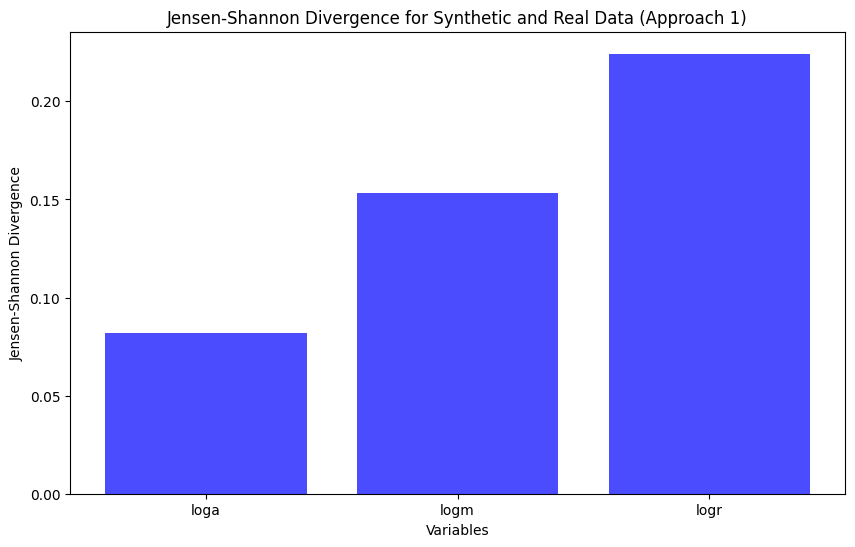

In [16]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

# Compute histograms for real and synthetic data (Approach 1)
real_hist_loga, _ = np.histogram(harder_data_sorted['loga'], bins=50, density=True)
real_hist_logm, _ = np.histogram(harder_data_sorted['logm'], bins=50, density=True)
real_hist_logr, _ = np.histogram(harder_data_sorted['logr'], bins=50, density=True)

synthetic_hist_loga_1, _ = np.histogram(synthetic_data_app1['loga'], bins=50, density=True)
synthetic_hist_logm_1, _ = np.histogram(synthetic_data_app1['logm'], bins=50, density=True)
synthetic_hist_logr_1, _ = np.histogram(synthetic_data_app1['logr'], bins=50, density=True)

# Compute Jensen-Shannon Divergence
js_loga_1 = jensenshannon(real_hist_loga, synthetic_hist_loga_1)
js_logm_1 = jensenshannon(real_hist_logm, synthetic_hist_logm_1)
js_logr_1 = jensenshannon(real_hist_logr, synthetic_hist_logr_1)

# Compute Earth Mover's Distance
emd_loga_1 = wasserstein_distance(harder_data_sorted['loga'], synthetic_data_app1['loga'])
emd_logm_1 = wasserstein_distance(harder_data_sorted['logm'], synthetic_data_app1['logm'])
emd_logr_1 = wasserstein_distance(harder_data_sorted['logr'], synthetic_data_app1['logr'])

# Create a DataFrame for easy copying
results_table_approach1 = pd.DataFrame({
    'Variable': ['loga', 'logm', 'logr'],
    'Jensen-Shannon Divergence': [js_loga_1, js_logm_1, js_logr_1],
    "Earth Mover's Distance": [emd_loga_1, emd_logm_1, emd_logr_1]
})

print(results_table_approach1)

# Visualize the results for Jensen-Shannon Divergence
variables = ['loga', 'logm', 'logr']
js_values = [js_loga_1, js_logm_1, js_logr_1]

plt.figure(figsize=(10, 6))
plt.bar(variables, js_values, color='blue', alpha=0.7)
plt.xlabel('Variables')
plt.ylabel('Jensen-Shannon Divergence')
plt.title('Jensen-Shannon Divergence for Synthetic and Real Data (Approach 1)')
plt.show()

# Visualize the results for Earth Mover's Distance
emd_values = [emd_loga_1, emd_logm_1, emd_logr_1]

# plt.figure(figsize=(10, 6))
# plt.bar(variables, emd_values, color='orange', alpha=0.7)
# plt.xlabel('Variables')
# plt.ylabel("Earth Mover's Distance")
# plt.title("Earth Mover's Distance for Synthetic and Real Data (Approach 1)")
# plt.show()

Results Approach 2:

  Variable  Jensen-Shannon Divergence  Earth Mover's Distance
0     loga                   0.090723                0.011990
1     logm                   0.148787                0.011495
2     logr                   0.140051                0.003919


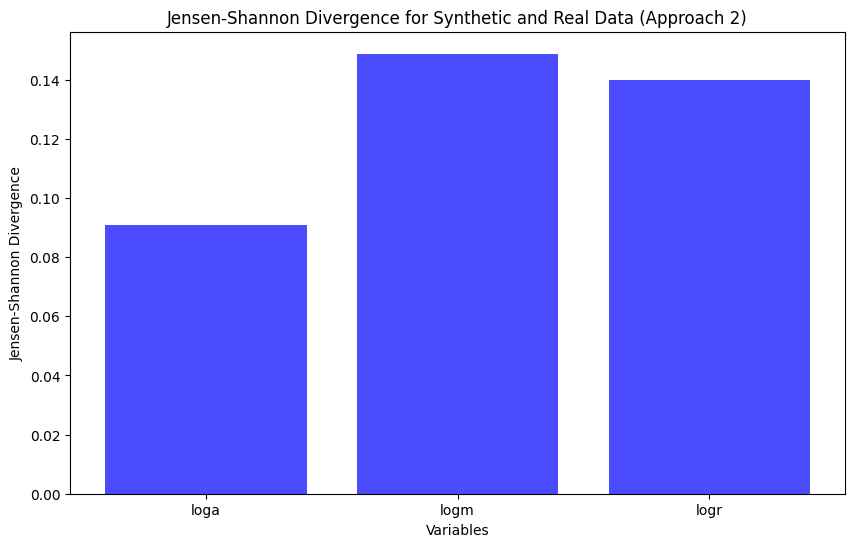

In [17]:
# Compute histograms for synthetic data (Approach 2)
synthetic_hist_loga_2, _ = np.histogram(synthetic_data_copula['loga'], bins=50, density=True)
synthetic_hist_logm_2, _ = np.histogram(synthetic_data_copula['logm'], bins=50, density=True)
synthetic_hist_logr_2, _ = np.histogram(synthetic_data_copula['logr'], bins=50, density=True)

# Compute Jensen-Shannon Divergence
js_loga_2 = jensenshannon(real_hist_loga, synthetic_hist_loga_2)
js_logm_2 = jensenshannon(real_hist_logm, synthetic_hist_logm_2)
js_logr_2 = jensenshannon(real_hist_logr, synthetic_hist_logr_2)

# Compute Earth Mover's Distance
emd_loga_2 = wasserstein_distance(harder_data_sorted['loga'], synthetic_data_copula['loga'])
emd_logm_2 = wasserstein_distance(harder_data_sorted['logm'], synthetic_data_copula['logm'])
emd_logr_2 = wasserstein_distance(harder_data_sorted['logr'], synthetic_data_copula['logr'])

# Create a DataFrame for easy copying
results_table_approach2 = pd.DataFrame({
    'Variable': ['loga', 'logm', 'logr'],
    'Jensen-Shannon Divergence': [js_loga_2, js_logm_2, js_logr_2],
    "Earth Mover's Distance": [emd_loga_2, emd_logm_2, emd_logr_2]
})

print(results_table_approach2)

# Visualize the results for Jensen-Shannon Divergence
js_values_2 = [js_loga_2, js_logm_2, js_logr_2]
variables = ['loga', 'logm', 'logr']

plt.figure(figsize=(10, 6))
plt.bar(variables, js_values_2, color='blue', alpha=0.7)
plt.xlabel('Variables')
plt.ylabel('Jensen-Shannon Divergence')
plt.title('Jensen-Shannon Divergence for Synthetic and Real Data (Approach 2)')
plt.show()

# Visualize the results for Earth Mover's Distance
emd_values_2 = [emd_loga_2, emd_logm_2, emd_logr_2]

# plt.figure(figsize=(10, 6))
# plt.bar(variables, emd_values_2, color='orange', alpha=0.7)
# plt.xlabel('Variables')
# plt.ylabel("Earth Mover's Distance")
# plt.title("Earth Mover's Distance for Synthetic and Real Data (Approach 2)")
# plt.show()

Results Approach 3:

  Variable  Jensen-Shannon Divergence  Earth Mover's Distance
0     loga                   0.289681                0.210485
1     logm                   0.653342                0.287225
2     logr                   0.398512                0.505497


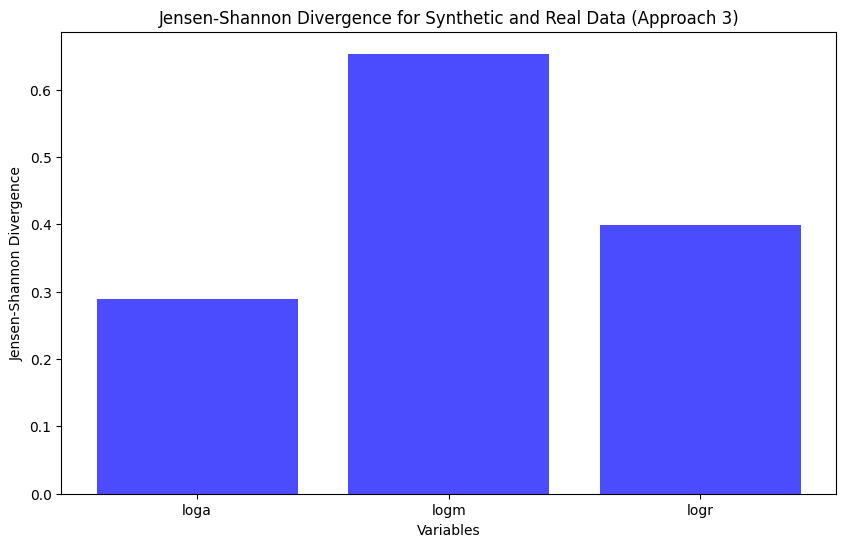

In [18]:
# Compute histograms for synthetic data (Approach 3)
synthetic_hist_loga_3, _ = np.histogram(synthetic_data_hierarchical['loga'], bins=50, density=True)
synthetic_hist_logm_3, _ = np.histogram(synthetic_data_hierarchical['logm'], bins=50, density=True)
synthetic_hist_logr_3, _ = np.histogram(synthetic_data_hierarchical['logr'], bins=50, density=True)

# Compute Jensen-Shannon Divergence
js_loga_3 = jensenshannon(real_hist_loga, synthetic_hist_loga_3)
js_logm_3 = jensenshannon(real_hist_logm, synthetic_hist_logm_3)
js_logr_3 = jensenshannon(real_hist_logr, synthetic_hist_logr_3)

# Compute Earth Mover's Distance
emd_loga_3 = wasserstein_distance(harder_data_sorted['loga'], synthetic_data_hierarchical['loga'])
emd_logm_3 = wasserstein_distance(harder_data_sorted['logm'], synthetic_data_hierarchical['logm'])
emd_logr_3 = wasserstein_distance(harder_data_sorted['logr'], synthetic_data_hierarchical['logr'])

# Create a DataFrame for easy copying
results_table_approach3 = pd.DataFrame({
    'Variable': ['loga', 'logm', 'logr'],
    'Jensen-Shannon Divergence': [js_loga_3, js_logm_3, js_logr_3],
    "Earth Mover's Distance": [emd_loga_3, emd_logm_3, emd_logr_3]
})

print(results_table_approach3)

# Visualize the results for Jensen-Shannon Divergence
js_values_3 = [js_loga_3, js_logm_3, js_logr_3]
variables = ['loga', 'logm', 'logr']

plt.figure(figsize=(10, 6))
plt.bar(variables, js_values_3, color='blue', alpha=0.7)
plt.xlabel('Variables')
plt.ylabel('Jensen-Shannon Divergence')
plt.title('Jensen-Shannon Divergence for Synthetic and Real Data (Approach 3)')
plt.show()

# Visualize the results for Earth Mover's Distance
emd_values_3 = [emd_loga_3, emd_logm_3, emd_logr_3]

# plt.figure(figsize=(10, 6))
# plt.bar(variables, emd_values_3, color='orange', alpha=0.7)
# plt.xlabel('Variables')
# plt.ylabel("Earth Mover's Distance")
# plt.title("Earth Mover's Distance for Synthetic and Real Data (Approach 3)")
# plt.show()

Results Approach 4:

  Variable  Jensen-Shannon Divergence  Earth Mover's Distance
0     loga                   0.302615                0.299256
1     logm                   0.731556                0.445002
2     logr                   0.532265                0.284811


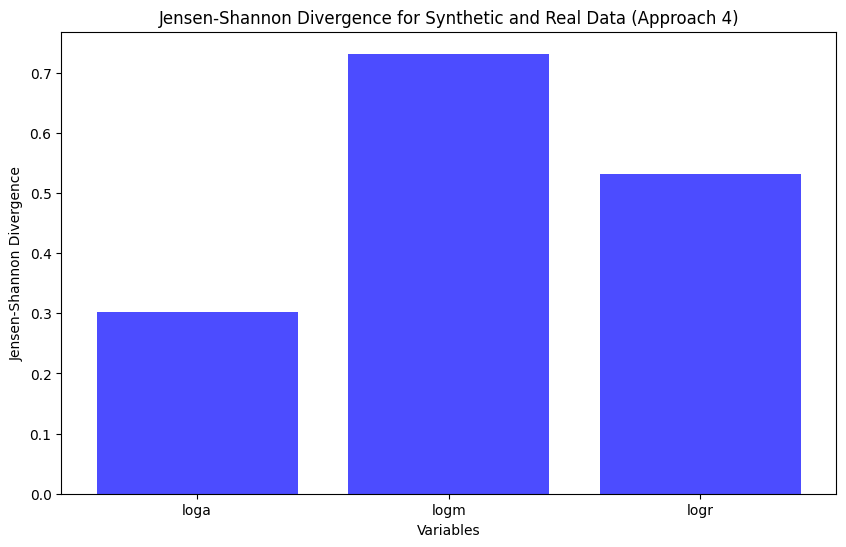

In [19]:
# Compute histograms for synthetic data (Approach 4)
synthetic_hist_loga_4, _ = np.histogram(synthetic_data_appr4['loga'], bins=50, density=True)
synthetic_hist_logm_4, _ = np.histogram(synthetic_data_appr4['logm'], bins=50, density=True)
synthetic_hist_logr_4, _ = np.histogram(synthetic_data_appr4['logr'], bins=50, density=True)

# Compute Jensen-Shannon Divergence
js_loga_4 = jensenshannon(real_hist_loga, synthetic_hist_loga_4)
js_logm_4 = jensenshannon(real_hist_logm, synthetic_hist_logm_4)
js_logr_4 = jensenshannon(real_hist_logr, synthetic_hist_logr_4)

# Compute Earth Mover's Distance
emd_loga_4 = wasserstein_distance(harder_data_sorted['loga'], synthetic_data_appr4['loga'])
emd_logm_4 = wasserstein_distance(harder_data_sorted['logm'], synthetic_data_appr4['logm'])
emd_logr_4 = wasserstein_distance(harder_data_sorted['logr'], synthetic_data_appr4['logr'])

# Create a DataFrame for easy copying
results_table_approach4 = pd.DataFrame({
    'Variable': ['loga', 'logm', 'logr'],
    'Jensen-Shannon Divergence': [js_loga_4, js_logm_4, js_logr_4],
    "Earth Mover's Distance": [emd_loga_4, emd_logm_4, emd_logr_4]
})

print(results_table_approach4)

# Visualize the results for Jensen-Shannon Divergence
js_values_4 = [js_loga_4, js_logm_4, js_logr_4]
variables = ['loga', 'logm', 'logr']

plt.figure(figsize=(10, 6))
plt.bar(variables, js_values_4, color='blue', alpha=0.7)
plt.xlabel('Variables')
plt.ylabel('Jensen-Shannon Divergence')
plt.title('Jensen-Shannon Divergence for Synthetic and Real Data (Approach 4)')
plt.show()

# Visualize the results for Earth Mover's Distance
emd_values_4 = [emd_loga_4, emd_logm_4, emd_logr_4]

# plt.figure(figsize=(10, 6))
# plt.bar(variables, emd_values_4, color='orange', alpha=0.7)
# plt.xlabel('Variables')
# plt.ylabel("Earth Mover's Distance")
# plt.title("Earth Mover's Distance for Synthetic and Real Data (Approach 4)")
# plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f66458fe-58be-4339-9cd1-dfb63a7ea0d4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>